In [1]:
import json
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import SimpleRNN, GRU, LSTM
from keras.layers.core import Dense, Dropout
from keras.layers.wrappers import TimeDistributed
from keras.layers import Convolution1D, MaxPooling1D
from keras.utils import np_utils
import itertools
import ast
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import sys, os
import traceback
from itertools import chain
import numpy as np
import pandas as pd

import progressbar

import tensorflow as tf
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
def read_data(rootdir):
    data_list = []
    for subdir, dirs, files in os.walk(rootdir):
        for fname in files:
            #print os.path.join(subdir, file)
            filepath = subdir + os.sep + fname
            with open(filepath) as f:
                for line1,line2 in itertools.izip_longest(*[f]*2):
                    try:
                        text = ast.literal_eval(line1)
                        label = ast.literal_eval(line2)
                        n_labels = set(label)
                        if len(text) > 3 and len(n_labels) > 1:
                            sentence = zip(text, label)
                            sentence = [item for item in sentence if item[0].strip() != '']
                            data_list.append(sentence)
                    except:
                        pass
            f.close()
    return data_list

In [6]:
data_list = read_data('../data/input/output_so/')

print data_list[0]

# data_list = data_list[:3000]

# words = list(chain.from_iterable(data_list))
# print words

words = list(set(y[0] for x in data_list for y in x))
words.append("ENDPAD")
n_words = len(words); n_words

tags = list(set(y[1] for x in data_list for y in x))
n_tags = len(tags); n_tags

[('A', 'NA'), ('Hybrid', 'NA'), ('Photoreceptor', 'NA'), ('Expressing', 'NA'), ('Both', 'NA'), ('Rod', 'NA'), ('and', 'NA'), ('Cone', 'NA'), ('Genes', 'SO:0000704'), ('in', 'NA'), ('a', 'NA'), ('Mouse', 'NA'), ('Model', 'NA'), ('of', 'NA'), ('Enhanced', 'NA'), ('SCone', 'NA'), ('Syndrome', 'NA')]


155

In [7]:
# from sklearn.preprocessing import LabelEncoder

# le = LabelEncoder()
# le.fit(list(y[1] for x in data_list for y in x))

# labels2idx = dict(zip(le.classes_, le.transform(le.classes_)))

# idx2la = {labels2idx[k]:k for k in labels2idx}

In [8]:
max_len = 75
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags, 1)}
tag2idx['0'] = 0
n_tags += 1

idx2tag = {v: k for k, v in tag2idx.iteritems()}

print word2idx['Hybrid']
print tag2idx["NA"]

1099
87


In [9]:
print tag2idx

{'SO:0000994': 1, 'SO:0000993': 2, 'SO:0000188': 3, 'SO:0000855': 5, 'SO:0000854': 6, 'SO:0000857': 7, 'SO:0000856': 8, 'SO:0000851': 9, 'SO:0000853': 10, 'SO:0000667': 11, 'SO:0001077': 12, 'SO:0000859': 13, 'SO:0000858': 14, 'SO:0001452': 15, 'SO:0001453': 16, 'SO:0001450': 17, 'SO:0001451': 18, 'SO:0001454': 19, 'SO:1000035': 20, 'SO:0000051': 21, 'SO:0000345': 22, '0': 0, 'SO:0000346': 23, 'SO:0000110': 24, 'SO:0000340': 25, 'SO:0000112': 26, 'SO:0000296': 27, 'SO:0001183': 28, 'SO:0001185': 29, 'SO:0001059': 30, 'SO:0000860': 31, 'SO:0000865': 32, 'SO:0000902': 33, 'SO:0001442': 34, 'SO:0000906': 35, 'SO:0000673': 36, 'SO:0001444': 37, 'SO:0001441': 38, 'SO:0001114': 39, 'SO:0001445': 40, 'SO:0000771': 41, 'SO:0001447': 42, 'SO:0001446': 43, 'SO:0000068': 44, 'SO:0001448': 45, 'SO:0000104': 46, 'SO:0000984': 47, 'SO:0000577': 48, 'SO:0000879': 49, 'SO:0000252': 50, 'SO:0000646': 51, 'SO:0001025': 152, 'SO:0000077': 54, 'SO:0000360': 55, 'SO:0000407': 56, 'SO:0000988': 57, 'SO:0000

In [10]:
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in data_list]

In [11]:
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=-1)

In [12]:
y = [[tag2idx[w[1]] for w in s] for s in data_list]

In [13]:
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["NA"])

In [14]:
from keras.utils import to_categorical

y = [to_categorical(i, num_classes=n_tags) for i in y]

In [15]:
from sklearn.model_selection import train_test_split

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3)

In [16]:
# from sklearn.utils import class_weight
# import numpy as np

# cw = class_weight.compute_class_weight('balanced',
#                                                  np.unique(y_tr),
#                                                  y_tr)

In [17]:
print np.shape(X_tr), np.shape(X_te), np.shape(y_tr), np.shape(y_te)

(2012, 75) (863, 75) (2012, 75, 156) (863, 75, 156)


In [18]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF

input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words + 1, output_dim=100,
                  input_length=max_len, mask_zero=True)(input)  # 20-dim embedding
model = Bidirectional(LSTM(units=100, return_sequences=True,
                           recurrent_dropout=0.25))(model)  # variational biLSTM
model = TimeDistributed(Dense(n_tags, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags)  # CRF layer
out = crf(model)  # output

In [19]:
model = Model(input, out)

In [20]:
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

In [21]:
model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 75, 100)           2014100   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 75, 200)           160800    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 75, 156)           31356     
_________________________________________________________________
crf_1 (CRF)                  (None, 75, 156)           49140     
Total params: 2,255,396
Trainable params: 2,255,396
Non-trainable params: 0
_________________________________________________________________


In [22]:
history = model.fit(X_tr, np.array(y_tr), batch_size=32, epochs=15,
                    validation_data=(X_te, np.array(y_te)), class_weight = 'auto', verbose=1)

Train on 2012 samples, validate on 863 samples
Epoch 1/15
2012/2012 [==============================] - 26s 13ms/step - loss: 0.6615 - viterbi_acc: 0.9303 - val_loss: 0.3231 - val_viterbi_acc: 0.9626
Epoch 2/15
2012/2012 [==============================] - 25s 12ms/step - loss: 0.3014 - viterbi_acc: 0.9604 - val_loss: 0.2467 - val_viterbi_acc: 0.9626
Epoch 3/15
2012/2012 [==============================] - 25s 12ms/step - loss: 0.2080 - viterbi_acc: 0.9622 - val_loss: 0.1675 - val_viterbi_acc: 0.9675
Epoch 4/15
2012/2012 [==============================] - 25s 12ms/step - loss: 0.1605 - viterbi_acc: 0.9668 - val_loss: 0.1399 - val_viterbi_acc: 0.9702
Epoch 5/15
2012/2012 [==============================] - 25s 12ms/step - loss: 0.1378 - viterbi_acc: 0.9689 - val_loss: 0.1276 - val_viterbi_acc: 0.9732
Epoch 6/15
2012/2012 [==============================] - 25s 12ms/step - loss: 0.1217 - viterbi_acc: 0.9724 - val_loss: 0.1127 - val_viterbi_acc: 0.9753
Epoch 7/15
2012/2012 [===================

In [23]:
hist = pd.DataFrame(history.history)

In [24]:
print hist

        loss  val_loss  val_viterbi_acc  viterbi_acc
0   0.661516  0.323120         0.962580     0.930272
1   0.301364  0.246670         0.962580     0.960404
2   0.207996  0.167531         0.967493     0.962207
3   0.160543  0.139865         0.970197     0.966806
4   0.137817  0.127640         0.973210     0.968893
5   0.121743  0.112731         0.975326     0.972372
6   0.107976  0.099677         0.978664     0.975620
7   0.093947  0.090374         0.981707     0.978847
8   0.080941  0.078943         0.984797     0.982260
9   0.069473  0.070017         0.987223     0.985189
10  0.058925  0.062103         0.988088     0.987349
11  0.050263  0.058328         0.989602     0.989085
12  0.042908  0.053865         0.990483     0.990808
13  0.036229  0.066298         0.990344     0.992121
14  0.030304  0.056291         0.991209     0.993154


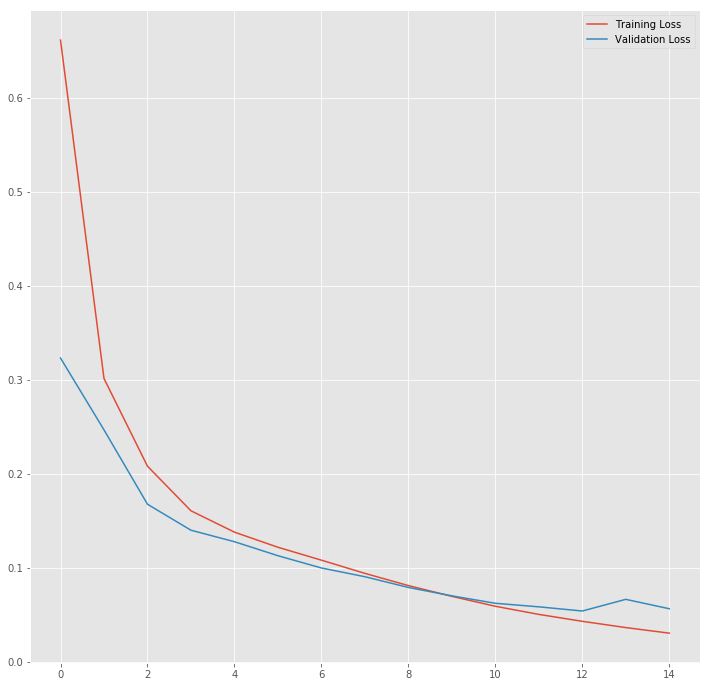

In [25]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["loss"], label='Training Loss')
plt.plot(hist["val_loss"], label='Validation Loss')
plt.legend()
plt.show()

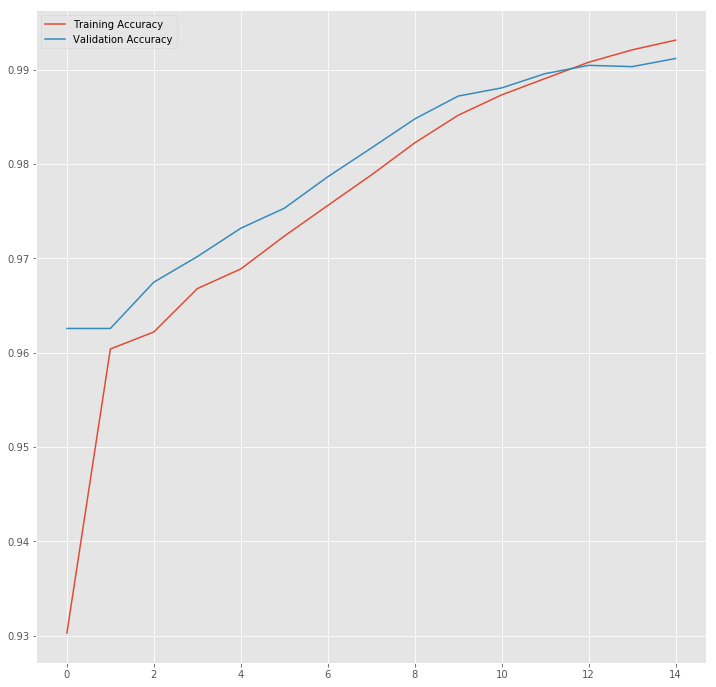

In [26]:
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["viterbi_acc"], label='Training Accuracy')
plt.plot(hist["val_viterbi_acc"], label='Validation Accuracy')
plt.legend()
plt.show()

In [27]:
from sklearn.metrics import classification_report

predicted = model.predict(X_te)

true = []
predicted_val = []
for i in range(len(predicted[:20])):
    p_tmp = np.argmax(predicted[i], axis=-1)
    t_tmp = np.argmax(y_te[i], -1)
    predicted_val.append(p_tmp)
    true.append(t_tmp)

    
p = [list(map(lambda x: idx2tag[x], y)) for y in predicted_val]
t = [list(map(lambda x: idx2tag[x], y)) for y in true]

print predicted_val[2]
print true[2]


print p[2]
print t[2]

report = classification_report(list(itertools.chain.from_iterable(t)), 
                                    list(itertools.chain.from_iterable(p)))
print "\n"
print report

[26 87 52 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87
 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87
 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87
 87 87 87]
[22 87 52 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87
 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87
 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87
 87 87 87]
['SO:0000112', 'NA', 'SO:0000001', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA']
['SO:0000345', 'NA', 'SO:0000001', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'N

/home/sdmohant/.virtualenvs/deeplearn/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sdmohant/.virtualenvs/deeplearn/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [28]:
i = 300
pd = model.predict(np.array([X_te[i]]))
pd = np.argmax(pd, axis=-1)
true = np.argmax(y_te[i], -1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")

for w, t1, pred in zip(X_te[i], true, pd[0]):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w-1], tags[t1], tags[pred]))

Word           ||True ||Pred
transiently    : SO:0001018 SO:0001018
expressed      : SO:0001018 SO:0001018
growth         : SO:0001018 SO:0001018
and            : SO:0001018 SO:0001018
transcription  : SO:0001018 SO:0001018
factor         : SO:0001018 SO:0001018
genes          : SO:0001026 SO:0001026
Knowledge      : SO:0001018 SO:0001018
of             : SO:0001018 SO:0001018
the            : SO:0001018 SO:0001018
molecular      : SO:0001018 SO:0001018
basis          : SO:0001018 SO:0001018
of             : SO:0001018 SO:0001018
these          : SO:0001018 SO:0001018
changes        : SO:0001018 SO:0001018
in             : SO:0001018 SO:0001018
huntingtin     : SO:0001018 SO:0001018
deficient      : SO:0001018 SO:0001018
embryos        : SO:0001018 SO:0001018
should         : SO:0001018 SO:0001018
facilitate     : SO:0001018 SO:0001018
the            : SO:0001018 SO:0001018
identification : SO:0001018 SO:0001018
of             : SO:0001018 SO:0001018
the            : SO:0001018 SO:0001

In [29]:
import pandas as pd

df = pd.DataFrame(
{
    'Predicted' : list(itertools.chain.from_iterable(p)),
    'Ground Truth': list(itertools.chain.from_iterable(t))
}
)


In [30]:
df.to_csv('../data/results/SO_LSTM_Based.tsv', sep='\t')

In [31]:
%run ./accuracy/src/computeSim.py ../data/results/SO_LSTM_Based.tsv ../data/validation_data/SO_AllSubsumers.tsv

Mean semantic similarity:  0.811
